/home/iwata/.local/share/virtualenvs/Transformer_TimeSeriesForecasting-main-LRDpDuFD/lib/python3.8/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


学習時間: 1147.73 秒
処理: 1147.73 秒
1
MSE Loss(corrected): 0.0009


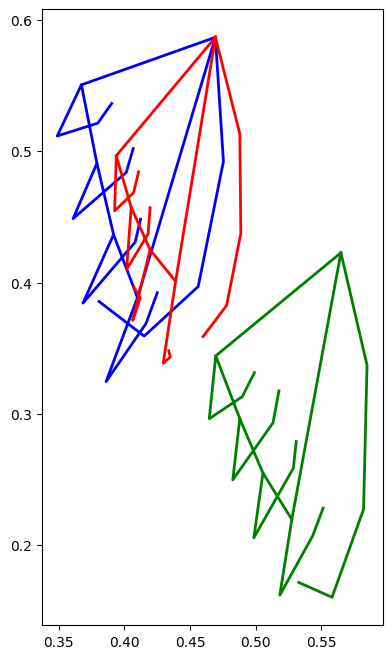

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
from torch.nn import TransformerEncoderLayer, LayerNorm, TransformerEncoder, TransformerDecoderLayer, TransformerDecoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mediapipe as mp
import random
import time
import cv2
import csv

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# フラットな手の座標をMediaPipe Handランドマークに変換する関数
def flatten_to_landmarks(coordinates):
    landmarks = []
    for i in range(0, len(coordinates), 3):
        landmarks.append((coordinates[i], coordinates[i + 1], coordinates[i + 2]))
    return landmarks

# データの読み込みと前処理
def preprocess_data(csv_path):
    df = pd.read_csv(csv_path)
    x_data = []
    y_data = []

    for i in range(len(df) - n_seq):
        x_sequence = df.iloc[i][[f'{j}_{c}' for j in range(num_joints) for c in ['x', 'y', 'z']]].values.flatten() 
        x_data.append(x_sequence)
        
        y_sequence = df.iloc[i+n_seq][[f'{j}_{c}' for j in range(num_joints) for c in ['x', 'y', 'z']]].values.flatten()
        y_data.append(y_sequence)

    x_data = np.array(x_data, dtype=np.float32)
    y_data = np.array(y_data, dtype=np.float32)

    return x_data, y_data

# DataLoaderの使用
def create_dataloader(x_train, y_train):
    train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    return train_loader

# モデルのパラメータ
#n_seq = 1
num_joints = 21
#input_size = num_joints * 3 * n_seq  # 各関節の座標 (x, y, z) を持つ
input_size = num_joints * 3 
hidden_size = 63
#output_size = num_joints # すべての関節の x 座標を予測
output_size = num_joints * 3
num_layers = 4
batch_size = 36
n_epochs = 100
embed_dim = 64
n_heads = 3

# 位置エンコーディングの定義
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout: float = 0.1, max_len: int = 5000) -> None:
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term[:pe[:, 1::2].size(1)])  # Adjust the size for odd d_model
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# モデルに入力するために次元を拡張する
class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        self.tokenConv = nn.Linear(c_in, d_model)

    def forward(self, x):
        x = self.tokenConv(x)
        return x

# Transformerモデルのアーキテクチャ
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, n_heads):
        super(TransformerModel, self).__init__()
        self.embedding = TokenEmbedding(input_size, hidden_size)
        self.positional_encoding = PositionalEncoding(hidden_size)
        encoder_layer = nn.TransformerEncoderLayer(hidden_size, n_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        decoder_layer = nn.TransformerDecoderLayer(hidden_size, n_heads)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        memory = self.transformer_encoder(x)
        out= self.transformer_decoder(x, memory)
        out = self.fc(out[:, -1, :])
        return out

# モデル、損失関数、オプティマイザ
model = TransformerModel(input_size, hidden_size, output_size, num_layers, n_heads).to(device)
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)


# ランドマークを(0.5, 0.5)にシフトする関数
def shift_landmarks(landmarks, target=(0.5, 0.5)):
    x_shift = target[0] - landmarks[0][0]
    y_shift = target[1] - landmarks[0][1]
    shifted_landmarks = [(x + x_shift, y + y_shift, z) for x, y, z in landmarks]
    return shifted_landmarks


# メインの処理
if __name__ == "__main__":
    # データの読み込みと前処理
    n_seq = 3


    #train_csv_path = 'test_10/choki_test_10/choki_test.csv'
    train_csv_path = '2_19_hand.csv'
    #train_csv_path = '2_19_hand_05.csv'

    
    #test_csv_path = 'test_5/gu_test_5/gu_test.csv'
    #test_csv_path = 'test_5/choki_test_5/choki_test.csv'
    #test_csv_path = 'test_5/pa-_test_5/pa-_test.csv'
    
    
    #test_csv_path = 'test_3/gu_test_3/gu_train.csv'
    test_csv_path = 'test_3/choki_test_3/choki_train.csv'
    #test_csv_path = 'test_3/pa-_test_3/pa-_train.csv'

    #test_csv_path = 'test_10/choki_test_10/choki_test_05.csv'
    
    
    x_train, y_train = preprocess_data(train_csv_path)
    x_test, y_test = preprocess_data(test_csv_path)
   
    # DataLoaderの作成
    train_loader = create_dataloader(x_train, y_train)



    #for i in range(1):
        #print("------ループ回数-------:", i+1)
    

    # トレーニングループ
    start_time = time.time()
    for epoch in range(n_epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.unsqueeze(1).to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        scheduler.step()

    training_time = time.time() - start_time
    print(f'学習時間: {training_time:.2f} 秒')

    # テストデータで評価
    model.eval()
    with torch.no_grad():
        start_time = time.time()
        test_outputs = model(torch.tensor(x_test, dtype=torch.float32).unsqueeze(1).to(device))
        test_loss = criterion(test_outputs, torch.tensor(y_test, dtype=torch.float32).to(device))
        processing_time_per_image = time.time() - start_time
        print(f'処理: {training_time:.2f} 秒')


    #  3つのテストサンプルごとに予測結果を処理し、1つずつずらして繰り返す
    window_size = 3  # ウィンドウサイズ（処理するテストサンプルの数）

    for sample_index in range(0, len(x_test)):  # ウィンドウを1つずつずらして処理する
    #for sample_index in range(0, len(x_test) - window_size + 1):  # ウィンドウを1つずつずらして処理する
        # ウィンドウ内のテストサンプルを取得
        x_test_batch = torch.tensor(x_test[sample_index:sample_index+window_size], dtype=torch.float32).unsqueeze(1).to(device)
        y_test_batch = torch.tensor(y_test[sample_index:sample_index+window_size], dtype=torch.float32).to(device)
        print(sample_index+1)

        with torch.no_grad():
            # 既存のモデルでx_testを予測
            start_time = time.time()
            predicted_tensor_x = model(x_test_batch)
            predicted_x = predicted_tensor_x.cpu().numpy()
            
            ground_truth_landmarks = flatten_to_landmarks(y_test_batch[0])  # 修正
            truth_landmarks = flatten_to_landmarks(x_test[sample_index])
            sample_landmarks_x = flatten_to_landmarks(predicted_x[0])  # 予測結果を利用
            
            """"
            # ランドマークを(0.5, 0.5)にシフト
            ground_truth_landmarks = shift_landmarks(ground_truth_landmarks)
            sample_landmarks_x = shift_landmarks(sample_landmarks_x)
            truth_landmarks = shift_landmarks(truth_landmarks)
            """

            # landmark_0 の x 座標と y 座標の差分を計算し、表示する
            x_difference = y_test[sample_index][0] - predicted_x[0][0]
            y_difference = y_test[sample_index][1] - predicted_x[0][1]
          
            # sample_landmarks_xに含まれるすべてのデータを修正してリストに変換
            corrected = []
            for landmark in sample_landmarks_x:
                x_corrected = landmark[0] + x_difference
                y_corrected = landmark[1] + y_difference
                z_corrected = landmark[2]  # z座標は変更しないと仮定
                corrected.append((x_corrected, y_corrected, z_corrected))
    
            # リストに変換
            corrected = [list(landmark) for landmark in corrected]
            #print("corrected:", corrected)

            
            # ground_truth_landmarksとsample_landmarks_xをTensorに変換
            #print("ground_truth_landmarks:", ground_truth_landmarks)
            ground_truth_tensor = torch.tensor(ground_truth_landmarks, dtype=torch.float32)
            #print("ground_truth_landmarks:", ground_truth_landmarks)
            sample_landmarks_x_tensor = torch.tensor(sample_landmarks_x, dtype=torch.float32)
            # MSELossを計算
            loss = criterion(ground_truth_tensor, sample_landmarks_x_tensor)
            #print(f'MSE Loss(sample): {loss.item():.4f}')
            
            
            # ground_truth_landmarksとcorrectedをTensorに変換
            ground_truth_tensor = torch.tensor(ground_truth_landmarks, dtype=torch.float32)
            corrected_tensor = torch.tensor(corrected, dtype=torch.float32)
            # MSELossを計算
            loss = criterion(ground_truth_tensor, corrected_tensor)
            print(f'MSE Loss(corrected): {loss.item():.4f}')

          

            # プロットの設定
            save_path = f'/home/iwata/Pictures/TF_hand_{sample_index}_n{n_seq}_r_w{window_size}_{n_epochs}.png'
            fig, ax = plt.subplots(figsize=(8, 8))
            # プロットの範囲を統一
            #ax.set_xlim(0.3, 0.7)
            #ax.set_ylim(0.3, 0.7)
            ax.set_aspect('equal', 'box')
            ax.set_aspect('equal', 'box')

            # 手の座標点の順序を指定するリスト（例）
            custom_order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

            #ground_truth_landmarks
            max_index = max([max(points) for points in [[0, 1, 2, 3, 4], [0, 5, 6, 7, 8], [5, 9, 10, 11, 12], [9, 13, 14, 15, 16], [13, 17, 18, 19, 20], [0, 17]]])
            if max_index < len(ground_truth_landmarks):
                for points in [[0, 1, 2, 3, 4], [0, 5, 6, 7, 8], [5, 9, 10, 11, 12], [9, 13, 14, 15, 16], [13, 17, 18, 19, 20], [0, 17]]:
                    x_points = [ground_truth_landmarks[i][0] for i in points]
                    y_points = [ground_truth_landmarks[i][1] for i in points]
                    ax.plot(x_points, y_points, linestyle='-', color='blue', linewidth=2)
            else:
                print("Error: Index out of range in ground_truth_landmarks")

            #corrected
            max_index = max([max(points) for points in [[0, 1, 2, 3, 4], [0, 5, 6, 7, 8], [5, 9, 10, 11, 12], [9, 13, 14, 15, 16], [13, 17, 18, 19, 20], [0, 17]]])
            if max_index < len(corrected):
                for points in [[0, 1, 2, 3, 4], [0, 5, 6, 7, 8], [5, 9, 10, 11, 12], [9, 13, 14, 15, 16], [13, 17, 18, 19, 20], [0, 17]]:
                    x_points = [corrected[i][0] for i in points]
                    y_points = [corrected[i][1] for i in points]
                    ax.plot(x_points, y_points, linestyle='-', color='red', linewidth=2)
            else:
                print("Error: Index out of range in corrected")

            #truth_landmarks
            max_index = max([max(points) for points in [[0, 1, 2, 3, 4], [0, 5, 6, 7, 8], [5, 9, 10, 11, 12], [9, 13, 14, 15, 16], [13, 17, 18, 19, 20], [0, 17]]])
            if max_index < len(truth_landmarks):
                for points in [[0, 1, 2, 3, 4], [0, 5, 6, 7, 8], [5, 9, 10, 11, 12], [9, 13, 14, 15, 16], [13, 17, 18, 19, 20], [0, 17]]:
                    x_points = [truth_landmarks[i][0] for i in points]
                    y_points = [truth_landmarks[i][1] for i in points]
                    ax.plot(x_points, y_points, linestyle='-', color='green', linewidth=2)
            else:
                print("Error: Index out of range in truth_landmarks")

            #plt.legend()
            #print('aaa')
            # 画像を保存
            plt.savefig(save_path)

            # 画像を表示
            #plt.show()
